In [16]:
import csv
import json
import uuid
import datetime
import pandas as pd
from lxml import etree
from collections import defaultdict, Counter
from tqdm import tqdm_notebook as tqdm
import os
import matplotlib.pyplot as plt
import statistics
import numpy as np
from eMammal_helpers import clean_species_name, get_total_from_distribution, sort_dict_val_desc, plot_distribution, plot_histogram

In [12]:
# print all outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# auto reload external Python modules
%load_ext autoreload
%autoreload 2

# display Matplotlib figures inline and set default size
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (8.0, 3.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# eMammal dataset stats

Contact: Siyu Yang <yasiyu@microsoft.com>

Run this notebook with Python 3.

This notebook inspects the eMammal dataset we have in August 2018. A subset of this is sent to iMerit for bounding box annotations. The CSV at `csv_path` contains all the images that have been sent to iMerit for annotations in the first batch.


In [13]:
# configurations and paths
output_dir_path = '/home/yasiyu/yasiyu_temp'

csv_path = '/home/yasiyu/scripts/input/emammal_2018.08.20.csv'  # csv specifying the images sent for annotation

deployments_path = '/datadrive/emammal'


# constants
_people_tags = {
    'Bicycle',
    'Calibration Photos',
    'Camera Trapper',
    'camera trappper',
    'camera  trapper',
    'Homo sapien',
    'Homo sapiens',
    'Human, non staff',
    'Human, non-staff',
    'camera trappe',
    'Human non-staff',
    'Setup Pickup',
    'Vehicle'
}
PEOPLE_TAGS = {x.lower() for x in _people_tags}

_no_animal_tags = {'No Animal', 'no  animal', 'Time Lapse', 'Camera Misfire', 'False trigger', 'Blank'}
NO_ANIMAL_TAGS = {x.lower() for x in _no_animal_tags}

## Data

The original images and classification annotations are in the `emammal` container in the `wildlifeblobssc` storage account in the AI for Earth Development subscription. The `emammal` container holds collections named after the researcher responsible for them and a number indicating the batch. These were downloaded to the `bobcat` VM's 2TB data disk at `/datadrive/emammal`, forgoing the collection folder level. Scripts for downloading them to the data disk is at `database_tools/copy_and_unzip_emammal.py`. 

At `/datadrive/emammal`, each folder is one deployment. Each deployment folder contains the sequences of images and a .xml file with information such as timestamp and animal species labels.

There are a total of 3140 deployments in the 0McShea and 0Kays collections, and 126 in the 0Long collection.

A deployment is a set of image sequences specific in space and time. So a site name could be shared by multiple deployments. I suspect there is an issue with the two projects from China (p193 and p195) with how they name their deployments - they seem to have named some of them with the site name.

### First batch of annotations

Here we load the csv and an example xml file.

In [4]:
# did not work with 'utf-8'
data = pd.read_csv(csv_path, encoding='ISO-8859-1', header=0,
                   names=['projectID', 'projectName', 'deploymentID', 'siteName', 'speciesPresentCommon', 'imageID', 'annotationSetFileName']) 

In [5]:
data.sample(n=10)
# note that speciesPresentCommon is ; separated when there are more than one species present

,projectID,projectName,deploymentID,siteName,speciesPresentCommon,imageID,annotationSetFileName
14903,p166,Raleigh Backyard Sustainability Survey Project,d19867,B_Harris_Brushpile,eastern chipmunk,d19867s10i3,datasetemammal.projectp166.deploymentd19867.se...
17823,3191,Urban to Wild Project,d28188,VWL Drake Ru 4_17,eastern gray squirrel,d28188s10i3,datasetemammal.project3191.deploymentd28188.se...
4569,p122,Museums Connect India,d17171,Jaisewa Adarsh Highschool (Pench) 23,northern plains gray langur,d17171s25i3,datasetemammal.projectp122.deploymentd17171.se...
3250,p193,Minshan Mountains Project,L-HTL12-D01A,L-HTL12-D01A,siberian weasel,L-HTL12-D01A-006,datasetemammal.projectp193.deploymentL-HTL12-D...
12467,3062,Prairie Ridge Project,d18512,Prairie Ridge 20 2015 Fall,coyote,d18512s14i3,datasetemammal.project3062.deploymentd18512.se...
1911,p135,Carnivore Intraguild Interactions in Select Th...,d16744,HKK11,common palm civet,d16744s13i3,datasetemammal.projectp135.deploymentd16744.se...
6052,p104,Museums Connect United States,d16316,East Cary 12,northern raccoon,d16316s12i4,datasetemammal.projectp104.deploymentd16316.se...
2531,p135,Carnivore Intraguild Interactions in Select Th...,d20609,HKK90,gaur,d20609s12i2,datasetemammal.projectp135.deploymentd20609.se...
17424,3191,Urban to Wild Project,d21418,VWL Springhouse Farm Sm 8_16,unknown animal,d21418s1i1,datasetemammal.project3191.deploymentd21418.se...
12415,3062,Prairie Ridge Project,d17131,Prairie Ridge 2014 Fall 32_Real,eastern gray squirrel,d17131s11i3,datasetemammal.project3062.deploymentd17131.se...


In [6]:
len(data)  # 18418 images are getting bbox annotations

18418

In [7]:
data.loc[3, 'annotationSetFileName']  # annotationSetFileName example

'datasetemammal.projectp100.deploymentd17432.seqd17432s11.frame004.imgd17432s11i4.jpg'

In [8]:
sorted(data.projectID.unique())

['3062',
 '3191',
 '4180',
 'p100',
 'p101',
 'p104',
 'p117',
 'p122',
 'p125',
 'p126',
 'p135',
 'p166',
 'p168',
 'p193',
 'p195']

Project p126 is not found in blob storage...

In [10]:
data[data.projectID == 'p126']

,projectID,projectName,deploymentID,siteName,speciesPresentCommon,imageID,annotationSetFileName
2832,p126,Independent Camera Trap Survey Project,d19315,RaleighBYO 436,white-tailed deer,d19315s10i1,datasetemammal.projectp126.deploymentd19315.se...
2833,p126,Independent Camera Trap Survey Project,d19315,RaleighBYO 436,white-tailed deer,d19315s10i2,datasetemammal.projectp126.deploymentd19315.se...
2834,p126,Independent Camera Trap Survey Project,d19315,RaleighBYO 436,white-tailed deer,d19315s10i3,datasetemammal.projectp126.deploymentd19315.se...
2835,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i1,datasetemammal.projectp126.deploymentd18463.se...
2836,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i10,datasetemammal.projectp126.deploymentd18463.se...
2837,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i2,datasetemammal.projectp126.deploymentd18463.se...
2838,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i3,datasetemammal.projectp126.deploymentd18463.se...
2839,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i4,datasetemammal.projectp126.deploymentd18463.se...
2840,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i5,datasetemammal.projectp126.deploymentd18463.se...
2841,p126,Independent Camera Trap Survey Project,d18463,RaleighBYO 328,eastern gray squirrel,d18463s1i6,datasetemammal.projectp126.deploymentd18463.se...


In [8]:
all_annotated_img = data['annotationSetFileName']
frames = [x.split('.frame')[1].split('.')[0] for x in all_annotated_img]

In [9]:
possible_frames = set(frames)
possible_frames

{'001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018'}

Note that the seq ID can just be `s11` without the deployment ID `d17432` prefix. But that's how it is in the `<ImageSequenceId>` item.


No "human" images were included in the annotation set.

In [10]:
sample_xml_path = '/datadrive/emammal/4180d18095/deployment_manifest.xml'

In [11]:
with open(sample_xml_path, 'r') as f:
    tree = etree.parse(sample_xml_path)
root = tree.getroot()
for child in root:
    print(child)

<Element ProjectId at 0x7fbe25f5bf08>
<Element ProjectName at 0x7fbe25f5b7c8>
<Element ProjectObjectives at 0x7fbe25f5bcc8>
<Element PublishDate at 0x7fbe25f5ba88>
<Element ProjectOwners at 0x7fbe25f5b7c8>
<Element PrincipalInvestigators at 0x7fbe25f5bf08>
<Element ProjectContacts at 0x7fbe25f5bcc8>
<Element ProjectLatitude at 0x7fbe25f5b7c8>
<Element ProjectLongitude at 0x7fbe25f5ba88>
<Element CountryCode at 0x7fbe25f5bf08>
<Element ProjectDataAccessandUseConstraints at 0x7fbe25f5b7c8>
<Element SubProjectId at 0x7fbe25f5bcc8>
<Element SubProjectName at 0x7fbe25f5bf08>
<Element SubProjectDesign at 0x7fbe25f5ba88>
<Element PlotName at 0x7fbe25f5b7c8>
<Element PlotTreatment at 0x7fbe25f5bf08>
<Element CameraDeploymentID at 0x7fbe25f5bcc8>
<Element CameraSiteName at 0x7fbe25f5ba88>
<Element Originators at 0x7fbe25f5bf08>
<Element ProposedCameraDeploymentBeginDate at 0x7fbe25f5b7c8>
<Element ProposedCameraDeploymentEndDate at 0x7fbe25f5bcc8>
<Element ProposedLatitude at 0x7fbe25f5bf08>
<E

In [12]:
tree.findtext('ProjectId')

'4180'

In [13]:
tree.find('CameraDeploymentID').text

'd18095'

In [14]:
sequence = tree.find('ImageSequence')
for child in sequence:
    print(child)

print('')

# species is only identified at the sequence level, not image level
research_ids = sequence.find('ResearcherIdentifications')
example_id = research_ids[0]
for c in example_id:
    print('{} - {}'.format(c, c.text))


print('\nImage has the following fields. The ImageIdentifications is empty.')    
for child2 in child:
    print(child2)

<Element ImageSequenceId at 0x7fbe25de5708>
<Element ImageSequenceBeginTime at 0x7fbe25de5788>
<Element ImageSequenceEndTime at 0x7fbe25f5ba88>
<Element VolunteerIdentifications at 0x7fbe25f5bf08>
<Element ResearcherIdentifications at 0x7fbe25de5808>
<Element Image at 0x7fbe25f5ba88>
<Element Image at 0x7fbe25f5bf08>
<Element Image at 0x7fbe25de5808>
<Element Image at 0x7fbe25f5ba88>
<Element Image at 0x7fbe25f5bf08>

<Element IUCNId at 0x7fbe25de5888> - 4
<Element TSNId at 0x7fbe25de58c8> - 4
<Element SpeciesScientificName at 0x7fbe25de5908> - Camera Trapper
<Element SpeciesCommonName at 0x7fbe25de5888> - Camera Trapper
<Element Count at 0x7fbe25de58c8> - 1
<Element Age at 0x7fbe25de5908> - None
<Element Sex at 0x7fbe25de5888> - None
<Element IndividualId at 0x7fbe25de58c8> - None
<Element AnimalRecognizable at 0x7fbe25de5908> - None
<Element IndividualAnimalNotes at 0x7fbe25de5948> - None

Image has the following fields. The ImageIdentifications is empty.
<Element ImageId at 0x7fbe25

## Dataset stats

All of the result below (apart from where noted) are based on the entire eMammal dataset, not just the images that were sent for annotation.

It is quite fast (~30 seconds) to run the cell below, reading the 3140 xml files.

In [14]:
# What species are there
species_tally = defaultdict(int)

# How many animals of the same species are there in each sequence - the content of <Count>
# Note that even if the identification is "empty"/"no animal", the <Count> tag will still be 1
animal_counts = []

# How many <Identification> items are there in each sequence
num_identifications = []

# Sequence ID for all sequences that have more than one <Identification> : What species are present
seq_with_multi_ids = {}

# How many sequences are there in each deployment
num_sequences_in_d = []

# How many images are in each sequence
num_images_in_seq = []


# TODO Could get these info for each project separately.


total_num_deployments = len(os.listdir(deployments_path))

for deployment in tqdm(os.listdir(deployments_path)):
    deployment_path = os.path.join(deployments_path, deployment)
    manifest_path = os.path.join(deployment_path, 'deployment_manifest.xml')
    
    with open(manifest_path, 'r') as f:
        tree = etree.parse(f)
    
    root = tree.getroot()
    project_id = root.findtext('ProjectId')
    deployment_id = root.findtext('CameraDeploymentID')
    
    image_sequences = root.findall('ImageSequence')
    num_sequences_in_d.append(len(image_sequences))
    
    for sequence in image_sequences:
        images = sequence.findall('Image')
        num_images_in_seq.append(len(images))
        
        # get species info
        seq_id = sequence.findtext('ImageSequenceId')
        full_seq_id = 'datasetemammal.project{}.deployment{}.seq{}'.format(project_id, deployment_id, seq_id)
        
        researcher_identifications = sequence.findall('ResearcherIdentifications')
        
        for researcher_id in researcher_identifications:
            identifications = researcher_id.findall('Identification')
            num_identifications.append(len(identifications))
            multi_id_flag = True if len(identifications) > 1 else False
                
            species = []

            for id in identifications:
                species_common_name = clean_species_name(id.findtext('SpeciesCommonName'))
                species_tally[species_common_name] += 1
                
                species.append(species_common_name)

                count = id.findtext('Count')
                animal_counts.append(int(count))
                
            if multi_id_flag:
                seq_with_multi_ids[full_seq_id] = species

### Number of images, sequences and deployments

Total number of sequences in the dataset: 163169
Median of 24 sequences in a deployment, average of 49.96, min 1, max 1801


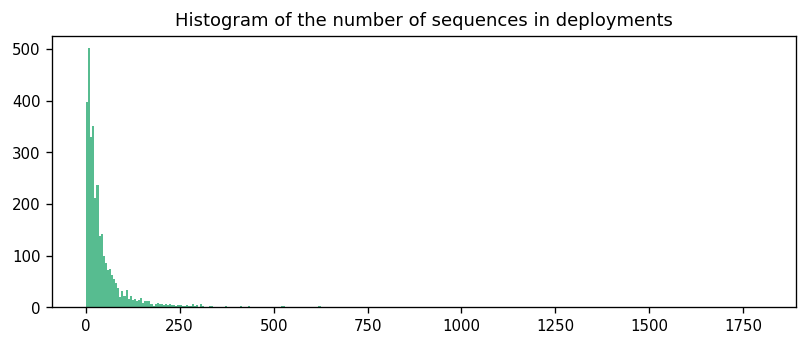

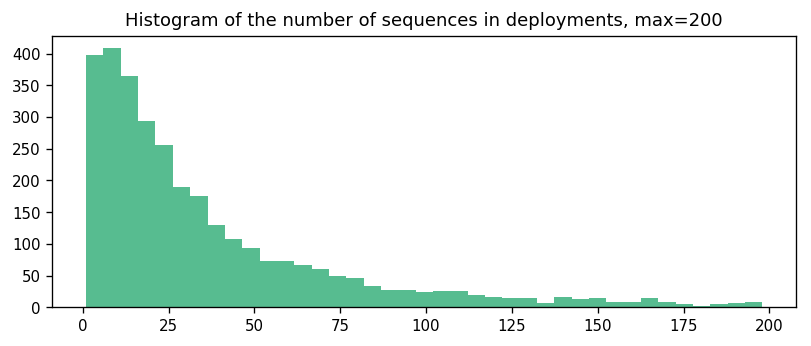

In [17]:
# Number of sequences in a deployment
print('Total number of sequences in the dataset: {}'.format(sum(num_sequences_in_d)))
print('Median of {:.0f} sequences in a deployment, average of {:.2f}, min {:.0f}, max {:.0f}'.format(
    np.median(num_sequences_in_d), 
    np.mean(num_sequences_in_d),
    min(num_sequences_in_d),
    max(num_sequences_in_d)))
plot_histogram(num_sequences_in_d, 'Histogram of the number of sequences in deployments')
plot_histogram(num_sequences_in_d, 'Histogram of the number of sequences in deployments, max=200', max_val=200)

Total number of images in the dataset: 1758921
Median of 5 images in a sequence, average of 10.78, min 1, max 1176


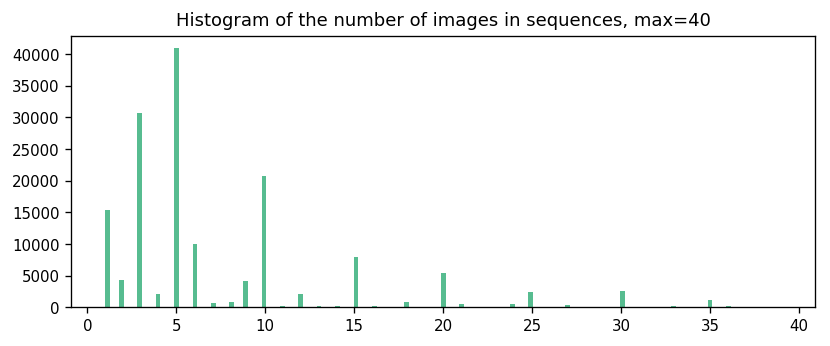

In [18]:
# Number of images/frames in a sequence
print('Total number of images in the dataset: {}'.format(sum(num_images_in_seq)))
print('Median of {:.0f} images in a sequence, average of {:.2f}, min {:.0f}, max {:.0f}'.format(
    np.median(num_images_in_seq), 
    np.mean(num_images_in_seq),
    min(num_images_in_seq),
    max(num_images_in_seq)))

plot_histogram(num_images_in_seq, 'Histogram of the number of images in sequences, max=40', max_val=40)

Verified that this number of images are present as .jpg:

In [19]:
total_num_images = 0

for deployment in tqdm(os.listdir(deployments_path)):
    deployment_path = os.path.join(deployments_path, deployment)
    content = os.listdir(deployment_path)
    num_images = sum(1 for i in content if i.lower().endswith('.jpg'))
    total_num_images += num_images
print('Total of {} images found.'.format(total_num_images))


Total of 1758921 images found.


### Species present

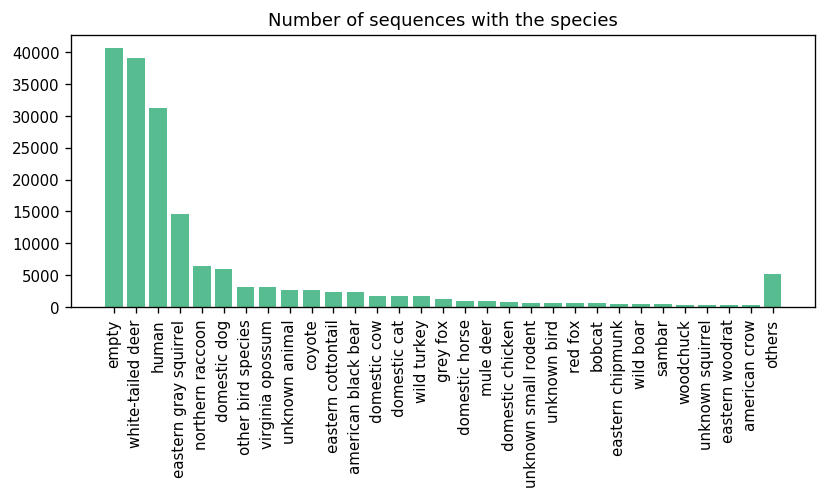

In [22]:
plot_distribution(species_tally, title='Number of sequences with the species', top=30)

In [23]:
sort_dict_val_desc(species_tally)

[('empty', 40604),
 ('white-tailed deer', 38997),
 ('human', 31285),
 ('eastern gray squirrel', 14545),
 ('northern raccoon', 6478),
 ('domestic dog', 5968),
 ('other bird species', 3173),
 ('virginia opossum', 3156),
 ('unknown animal', 2748),
 ('coyote', 2659),
 ('eastern cottontail', 2319),
 ('american black bear', 2305),
 ('domestic cow', 1800),
 ('domestic cat', 1758),
 ('wild turkey', 1738),
 ('grey fox', 1338),
 ('domestic horse', 992),
 ('mule deer', 983),
 ('domestic chicken', 736),
 ('unknown small rodent', 711),
 ('unknown bird', 705),
 ('red fox', 695),
 ('bobcat', 579),
 ('eastern chipmunk', 539),
 ('wild boar', 525),
 ('sambar', 496),
 ('woodchuck', 338),
 ('unknown squirrel', 319),
 ('eastern woodrat', 297),
 ('american crow', 293),
 ('takin', 277),
 ('eastern fox squirrel', 257),
 ('northern red muntjac', 244),
 ('unknown rabbit_hare', 182),
 ('unknown mouse or rat', 170),
 ('blood pheasant', 157),
 ('hog badger', 151),
 ('elk aka red deer', 139),
 ('northern plains gra

### Count tag `<Count>` 

An example where the count is 3 is `project3062d20814.deploymentd20814.sequenced20814s25`. There are 3 Northern Raccoons but no more than 2 appear in one image.

Inspecting a few others of such, count doesn't seem particularly useful. One labeled with count 3 could be 2 animals that becomes invisible in a few frames. 

As noted before, even if the identification is "empty"/"no animal", the <Count> tag will still be 1

In [24]:
print('Total number of Count item values in the dataset: {}'.format(sum(animal_counts)))
print('Median of {:.0f} for the Count item, average of {:.2f}, min {:.0f}, max {:.0f}'.format(
    np.median(animal_counts), 
    np.mean(animal_counts),
    min(animal_counts),
    max(animal_counts)))
counter = Counter(animal_counts)
print(counter)

Total number of Count item values in the dataset: 216697
Median of 1 for the Count item, average of 1.24, min 1, max 168
Counter({1: 149882, 2: 16592, 3: 4357, 4: 1670, 5: 675, 6: 376, 7: 212, 8: 131, 9: 91, 10: 48, 11: 40, 12: 37, 13: 29, 14: 19, 15: 17, 30: 14, 19: 13, 16: 12, 18: 9, 20: 9, 17: 8, 21: 5, 22: 4, 24: 4, 25: 4, 23: 3, 58: 2, 26: 1, 27: 1, 28: 1, 29: 1, 80: 1, 35: 1, 38: 1, 39: 1, 168: 1, 66: 1, 43: 1, 45: 1, 50: 1, 51: 1})


### Multiple animals or species in the same image sequence

Some image sequences contain more than one `<Identification>` item in `<ResearcherIdentifications>`. There is also a `<Count>` for each `<Identification>`, which seems to mean how many animals of that species are there. This is a little inconsistent: sometimes both `<Identification>` are of the same species as you can see below.

This is problematic because iMerit only labels bbox for one class 'animal', so when there are multiple bboxs in an image of different species, there's no way to label the bbox's species correctly (other than manually).

In [25]:
print('Total number of identification items in the dataset: {}'.format(sum(num_identifications)))
print('Median of {:.0f} identification items per sequence, average of {:.2f}, min {:.0f}, max {:.0f}'.format(
    np.median(num_identifications), 
    np.mean(num_identifications),
    min(num_identifications),
    max(num_identifications)))
counter = Counter(num_identifications)
print(counter)

Total number of identification items in the dataset: 174277
Median of 1 identification items per sequence, average of 1.07, min 1, max 10
Counter({1: 152483, 2: 10288, 3: 383, 4: 12, 5: 1, 6: 1, 10: 1})


152483 / 174277 = 87.5% images have just one identification item in the xml.

In [26]:
list(seq_with_multi_ids.values())[:20]  # what species are there in sequences with multiple identifications

[['white-tailed deer', 'white-tailed deer'],
 ['domestic dog', 'human'],
 ['domestic dog', 'human'],
 ['unknown animal', 'white-tailed deer'],
 ['eastern gray squirrel', 'eastern chipmunk'],
 ['white-tailed deer', 'white-tailed deer'],
 ['human', 'human'],
 ['human', 'domestic dog'],
 ['white-tailed deer', 'white-tailed deer'],
 ['cattle egret', 'domestic cow'],
 ['domestic dog', 'human'],
 ['domestic dog', 'human'],
 ['human', 'human'],
 ['white-tailed deer', 'white-tailed deer'],
 ['eastern gray squirrel', 'other bird species', 'domestic chicken'],
 ['domestic dog', 'human'],
 ['human', 'domestic dog', 'human'],
 ['human', 'human', 'human'],
 ['unknown animal', 'white-tailed deer'],
 ['domestic cat', 'white-tailed deer']]

In [27]:
all_annotated_img = data['annotationSetFileName']
all_annotated_seq = set([x.split('.frame')[0] for x in all_annotated_img])
len(all_annotated_seq)

2658

Here are all the species __in bbox annotated pictures__ with more than one identifications, that don't involve human or where all IDs are of the same species:

In [36]:
for seq_id, animals in seq_with_multi_ids.items():
    if seq_id in all_annotated_seq:
        if 'human' not in animals and len(set(animals)) > 1:
            print(animals)

['domestic cow', 'cattle egret']
['domestic cow', 'cattle egret']
['eastern gray squirrel', 'other bird species']
['eastern gray squirrel', 'other bird species']
['grey fox', 'white-tailed deer']
['unknown animal', 'grey fox']
['domestic goat', 'cattle egret']
['domestic cow', 'other bird species']
['white-tailed deer', 'unknown animal', 'domestic cat']
['domestic cow', 'cattle egret']
['domestic cow', 'cattle egret']
['siamese fireback', 'wild boar']
['unknown bird', 'chital']
['sambar', 'chital']
['white-tailed deer', 'eastern gray squirrel']
['virginia opossum', 'red fox']
['unknown bird', "collie's squirrel"]
['cattle egret', 'domestic cow']
['unknown animal', 'eastern cottontail']
['eastern gray squirrel', 'unknown squirrel']
['domestic cow', 'other bird species']
['bobcat', 'white-tailed deer']
['other bird species', 'eastern cottontail']
['other bird species', 'white-tailed deer']
['cattle egret', 'domestic cow']
['white-tailed deer', 'empty', 'empty']
['eastern cottontail', 'wh

So not that many images that are animals-only and contain more than one label. This is few enough to label manually.

## Notes

Some other names used for denoting human and empty sequences:
```
other_human_tags = {
    'camera  trapper', # extra whitespace or misspelt
    'camera trapper ',
    'camera trappper'
}

other_no_animal = {
    'animal not on list',  # should map to 'unknown animal'?
    'no  animal',  # extra whitespace
}
```

## Bounding box annotations

To come. 